# Tracing Task Analysis

In [1]:
import cv2
import numpy as np
import scipy.stats as stats
import os
import pandas as pd
import matplotlib
from matplotlib import pylab, mlab, pyplot
import svgpathtools

In [2]:
# file path
analysis_dir = os.getcwd()
tracing_dir = os.path.join(analysis_dir, 'tracing')
sketch_dir = os.path.join(analysis_dir, 'cumulative_drawings')
data_dir = os.path.join(analysis_dir, 'usage_data')

### Compute F1 Scores

In [20]:
tracing = ['square', 'shape', 'this circle']
f1_scores = []

for t_index, t in enumerate(tracing):
    # find the tracing image and corresponding sketch folder
    fname = t + '.png'
    fpath = os.path.join(tracing_dir,fname)
    img_trace = cv2.imread(fpath)
    
    # turn white pixels into black. Keep all pixels not on the shape black
    pixels_trace = np.argwhere(img_trace.sum(axis=2) == 255*3)
    for p in pixels_trace:
        img_trace[p[0]][p[1]] = [0,0,0]
    
    
    # add padding to the tracing image. In the experiment, the tracing image only occupied 70% of the canvas
    old_size = img_trace.shape[:2]
    print str(old_size)
    ratio = 0.7
    color = [0, 0, 0]
    new_width = old_size[1]/ratio
    left = int((new_width - old_size[1])/2)
    right = left
    top = int((new_width - old_size[0])/2)
    bottom = top
    img_trace = cv2.copyMakeBorder(img_trace, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    cv2.imwrite(os.path.join(tracing_dir, 'resize1_' + fname), img_trace)
        
    # resize the tracing image to the same size as the drawing image
    rows, cols = 150, 150 # the size of any drawing image
    img_trace = cv2.resize(img_trace, (rows, cols), interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(tracing_dir, 'resize_' + fname), img_trace)

    # get drawings from the sketchs folder
    for kid in os.listdir(sketch_dir):
        if not kid.startswith('cdm'): continue
            
        session_id = kid.split('_')[2]
        age = kid.split('_')[3].replace('age','')
        if age == 'adult':
            age = -1
        else:
            age = int(age)
                
        trace_folder = str(t_index) + '_' + t
        draw_img_dir = os.path.join(sketch_dir,kid,trace_folder)
        
        if not os.path.exists(draw_img_dir): continue
    
        ## calculate F1 score for drawings 
        
        # import drawing
        file_list = sorted(os.listdir(draw_img_dir))
        img = file_list[-1]
        draw_fname = os.path.join(draw_img_dir, img)
        img_draw = cv2.imread(draw_fname, cv2.IMREAD_UNCHANGED)

        # true positive: pixel was tracing shape & drawer traced there: number of pixels that overlapped (HITS)
        # false positive: pixel was not tracing shape & drawer traced there: number of pixels that were drawn NOT on the shape (false alarms)
        # true negative; pixel was NOT tracing shape & drawer DID not draw there (white pixels outside of tracing shape) (correct rejections)
        # false negatives: pixel WAS the tracing shape & drawer DID NOT tracer there: number of pixels that should have been traced and were not (MISS)
        true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0

        for i in range(rows):
            for j in range(cols):
                if sum(img_draw[i][j]) > 0:
                    if sum(img_trace[i][j])>0:
                        true_positive +=1
                    else:
                        false_positive += 1

                else:
                    if 255*3 > sum(img_trace[i][j]) > 0:
                        false_negative +=1
                    else:
                        true_negative += 1

        # calculate precision and recall
        precision, recall = 0, 0
        if true_positive != 0:
            precision = float(true_positive)/(true_positive + false_positive)
            recall = float(true_positive)/(true_positive + false_negative)

        # calculate the F1 score
        f1 = 0
        if precision + recall != 0:
            f1 = 2 * (precision * recall) / (precision + recall)

        f1_scores.append([session_id, age, t, f1])



(1200, 1200)
(949, 700)
(500, 500)


In [21]:
# write data to cvs files
print(len(f1_scores))
print (true_positive, true_negative, false_positive, false_negative)
print (img)
print f1

20
(839, 0, 21661, 0)
cdm_run_v31525895728803_2_this circle_4.png
0.0718968250568


In [22]:
# write data to csv files
data = pd.DataFrame(f1_scores)
data.columns = ['sessionID', 'age', 'tracing_item', 'f1_score']
data.to_csv(os.path.join(data_dir,'f1_scores_svg.csv'))

### Visualization

#### Basic Visualization

Text(0.5,0,u'f1_scores')

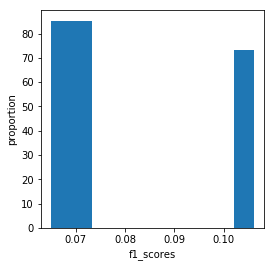

In [17]:
# show the F1 score ranges
plt = pyplot
fig = plt.figure(figsize=(4,4))
h = plt.hist(data.f1_score.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('f1_scores')

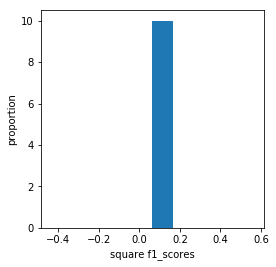

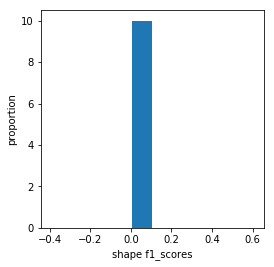

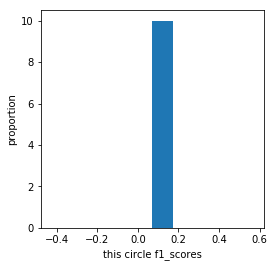

In [18]:
for index, t in enumerate(tracing):
    t_data = data.loc[data['tracing_item'] == t]
    fig = plt.figure(figsize=(4,4))
    h = plt.hist(t_data.f1_score.values,normed=True)
    plt.ylabel('proportion')
    plt.xlabel(t + ' f1_scores')

#### Age and F1 Scores (Absolute)

/Users/zixianchai/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/zixianchai/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


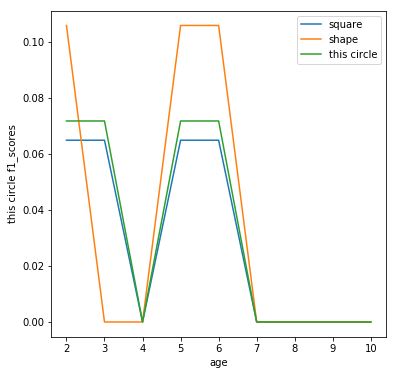

In [19]:
# Age and F1 score
min_age, max_age = 2, 10
age_range = range(min_age, max_age+1)

fig = plt.figure(figsize=(6,6))
line_list = []
for t in tracing:
    age_avg = []
    for age in age_range:
        current_age = data.loc[(data['age'] == age) & (data['tracing_item'] == t)]
        current_f1_scores = current_age.f1_score.values
        current_avg = np.average(current_f1_scores)
        if len(current_f1_scores)==0:
            age_avg.append(0)
        else:
            age_avg.append(current_avg)    

    p, = plt.plot(age_range, age_avg)
    line_list.append(p)
    plt.ylabel(t +' f1_scores')
    plt.xlabel('age')

plt.legend(line_list, tracing)


In [46]:
# correlations
for t in tracing:
    current_shape = data.loc[data['tracing_item'] == t]
    current_f1_scores = current_shape.f1_score.values
    current_age = current_shape.age.values
    print (t, stats.pearsonr(current_f1_scores, current_age))
#     corr = current_shape['age'].corr(current_shape['f1_score'])
#     print (t, corr)

('square', (0.4146606985452822, 1.3684085931921176e-25))
('shape', (0.44218904555980304, 4.605915072924256e-24))
('this circle', (0.29289594207151975, 6.496452786520216e-09))


#### Shape and F1 Scores

Text(0,0.5,u'average f1_scores')

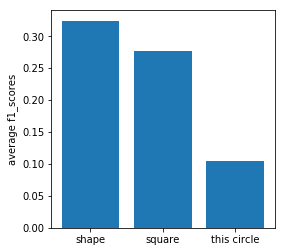

In [29]:
# Age and F1 score
tracing_avg = []
for t in tracing:
    current_shape = data.loc[(data['tracing_item'] == t)]
    current_f1_scores = current_shape.f1_score.values
    current_avg = np.average(current_f1_scores)
    if len(current_f1_scores)==0:
        tracing_avg.append(0)
    else:
        tracing_avg.append(current_avg)    

fig = plt.figure(figsize=(4,4))
p = plt.bar(tracing, tracing_avg)
plt.ylabel('average f1_scores')

